In [1]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

import openpyxl

In [2]:
dfFao = pd.read_csv("FAOSTAT.csv")
dfCountries = pd.read_csv("iso-country-codes.csv")
dfConsumption = pd.read_csv("oecd_meat_consumption.csv")

dfFao.head(2)

,Domain Code,Domain,Area Code (FAO),Area,Element Code,Element,Item Code (FAO),Item,Year Code,Year,Unit,Value,Flag,Flag Description
0,QCL,Crops and livestock products,2,Afghanistan,5510,Production,867,"Meat, cattle",1961,1961,tonnes,43000.0,F,FAO estimate
1,QCL,Crops and livestock products,2,Afghanistan,5510,Production,867,"Meat, cattle",1962,1962,tonnes,45800.0,F,FAO estimate


In [3]:
dfCountries.head(2)

,English short name lower case,Alpha-2 code,Alpha-3 code,Numeric code,ISO 3166-2
0,Zimbabwe,ZW,ZWE,716,ISO 3166-2:ZW
1,Zambia,ZM,ZMB,894,ISO 3166-2:ZM


In [4]:
dfConsumption.head(2)

,LOCATION,INDICATOR,SUBJECT,MEASURE,FREQUENCY,TIME,Value,Flag Codes
0,AUS,MEATCONSUMP,BEEF,KG_CAP,A,1990,0.000,NaN
1,AUS,MEATCONSUMP,BEEF,KG_CAP,A,1991,27.942,NaN


## Pasos para limpiar dfCountries
1. Seleccionar solo aquellas columnas necesarias.
2. Renombrar las columnas al igual que las columnas en los otros dataset para luego hacer los joins.
3. Revisar qué valores de dfCountries no hacen correspondencia con los códigos o nombres usados en los otros datasets.

### Paso 1 y 2

In [5]:
dfCountries = dfCountries[['Alpha-3 code', 'English short name lower case']] \
    .rename(columns={'Alpha-3 code': 'LOCATION', 'English short name lower case':'Area'})
dfCountries.head(5)

,LOCATION,Area
0,ZWE,Zimbabwe
1,ZMB,Zambia
2,YEM,Yemen
3,ESH,Western Sahara
4,WLF,Wallis and Futuna


### Paso 3: emparejado de valores

In [6]:
def unirDf(df1, df2, columna):
    df1 = df1.merge(df2, on=columna, how='left', indicator=True)
    print('valores que no hacen correspondencia:')
    print(df1[df1['_merge'] != 'both'])
    return df1


dfUnicosEnConsumo = pd.DataFrame(dfConsumption['LOCATION'].unique(), columns = ['LOCATION'])
dfJoinedConsumptionAndCountries = unirDf(dfUnicosEnConsumo, dfCountries, 'LOCATION')

valores que no hacen correspondencia:
   LOCATION Area     _merge
32      WLD  NaN  left_only
33     OECD  NaN  left_only
34    BRICS  NaN  left_only


Esto es esperado, pues el dataset de consumo de OEDC usa esos tres valores para poner valores especiales para su propio análisis.

Ahora, quitamos esos valores y revisamos cuáles valores no están en el dataset de producción de FAO.

In [7]:
dfConsumptionOK = dfJoinedConsumptionAndCountries[dfJoinedConsumptionAndCountries['_merge'] == 'both'][['Area']]

def corroborarValoresEnFAO(df):
    dfUnicosEnFao = pd.DataFrame(dfFao['Area'].unique(), columns = ['Area'])
    _ = unirDf(df, dfUnicosEnFao, 'Area')
    
corroborarValoresEnFAO(dfConsumptionOK)

valores que no hacen correspondencia:
              Area     _merge
3      South Korea  left_only
6           Turkey  left_only
7    United States  left_only
17            Iran  left_only
26          Russia  left_only
31         Vietnam  left_only
34  United Kingdom  left_only


Vale acotar que **FAO no tiene datos para Turquía**.

Correcciones a valores en dfFao

In [8]:
def corregirValorEnFao(malo, bueno, columma='Area'):
    dfFao.loc[dfFao[columma] == malo, columma] = bueno

corregirValorEnFao('Republic of Korea', 'South Korea')
corregirValorEnFao('United States of America', 'United States')
corregirValorEnFao('Iran (Islamic Republic of)', 'Iran')
corregirValorEnFao('Russian Federation', 'Russia')
corregirValorEnFao('Viet Nam', 'Vietnam')
corregirValorEnFao('United Kingdom of Great Britain and Northern Ireland', 'United Kingdom')
#Turquía se deja por fuera

corroborarValoresEnFAO(dfConsumptionOK)

valores que no hacen correspondencia:
     Area     _merge
6  Turkey  left_only


In [9]:
dfCountries.head(5)

,LOCATION,Area
0,ZWE,Zimbabwe
1,ZMB,Zambia
2,YEM,Yemen
3,ESH,Western Sahara
4,WLF,Wallis and Futuna


----

## Pasos para limpiar dfConsumption
Pasos:
1. Unir los datos de Consumo con los países.
2. Quitar los códigos de 'Location' propios del análisis de la OECD.
3. Remover entradas para Turquía.
4. Quitar columnas innecesarias.

### 1. Unir datos con dataframe de países

In [10]:
dfConsumption = dfConsumption.merge(dfCountries, on='LOCATION', how='left', indicator=True)
dfConsumption.head(5)

,LOCATION,INDICATOR,SUBJECT,MEASURE,FREQUENCY,TIME,Value,Flag Codes,Area,_merge
0,AUS,MEATCONSUMP,BEEF,KG_CAP,A,1990,0.000,NaN,Australia,both
1,AUS,MEATCONSUMP,BEEF,KG_CAP,A,1991,27.942,NaN,Australia,both
2,AUS,MEATCONSUMP,BEEF,KG_CAP,A,1992,26.405,NaN,Australia,both
3,AUS,MEATCONSUMP,BEEF,KG_CAP,A,1993,26.370,NaN,Australia,both
4,AUS,MEATCONSUMP,BEEF,KG_CAP,A,1994,25.662,NaN,Australia,both


In [11]:
dfConsumption[dfConsumption['_merge'] != 'both']['LOCATION'].unique()

array(['WLD', 'OECD', 'BRICS'], dtype=object)

### 2. Remover Location extras

Remover filas cuando el 'Location' es 'WLD', 'OECD' o 'BRICS'.

Esos son valores totales usados por OECD para comparaciones que no son necesarios para nuestro análisis.

In [12]:
dfConsumption = dfConsumption[dfConsumption['_merge'] == 'both']
dfConsumption.head(3)

,LOCATION,INDICATOR,SUBJECT,MEASURE,FREQUENCY,TIME,Value,Flag Codes,Area,_merge
0,AUS,MEATCONSUMP,BEEF,KG_CAP,A,1990,0.000,NaN,Australia,both
1,AUS,MEATCONSUMP,BEEF,KG_CAP,A,1991,27.942,NaN,Australia,both
2,AUS,MEATCONSUMP,BEEF,KG_CAP,A,1992,26.405,NaN,Australia,both


### 3. Remover Turquía

In [13]:
dfConsumption = dfConsumption[dfConsumption['Area'] != 'Turkey']

### 4. Columnas innecesarias
Descubriendo cuáles columnas son innecesarias:
- Location (se sustituye por Area).
- Flag Codes que son solo nulos.
- Frecuencia: que siempre es A de Anual.
- Indicador: que siempre es MEATCONSUMP.
- Columnas de códigos redundantes como Year Code, Item Code, Element Code, Area Code

In [14]:
dfConsumption['Flag Codes'].unique()

array([nan])

In [15]:
dfConsumption['FREQUENCY'].unique()

array(['A'], dtype=object)

In [16]:
dfConsumption['INDICATOR'].unique()

array(['MEATCONSUMP'], dtype=object)

In [17]:
dfConsumption = dfConsumption[['Area', 'SUBJECT', 'MEASURE', 'TIME', 'Value']]
dfConsumption.head(3)

,Area,SUBJECT,MEASURE,TIME,Value
0,Australia,BEEF,KG_CAP,1990,0.000
1,Australia,BEEF,KG_CAP,1991,27.942
2,Australia,BEEF,KG_CAP,1992,26.405


----

## Pasos para limpiar dfFao
Este dataset contiene datos de la producción total en toneladas.

Para nuestro análisis solo nos interesa la producción, para poder compararla con el consumo (dfConsumption).

In [18]:
dfFao.head(5)

,Domain Code,Domain,Area Code (FAO),Area,Element Code,Element,Item Code (FAO),Item,Year Code,Year,Unit,Value,Flag,Flag Description
0,QCL,Crops and livestock products,2,Afghanistan,5510,Production,867,"Meat, cattle",1961,1961,tonnes,43000.0,F,FAO estimate
1,QCL,Crops and livestock products,2,Afghanistan,5510,Production,867,"Meat, cattle",1962,1962,tonnes,45800.0,F,FAO estimate
2,QCL,Crops and livestock products,2,Afghanistan,5510,Production,867,"Meat, cattle",1963,1963,tonnes,47250.0,F,FAO estimate
3,QCL,Crops and livestock products,2,Afghanistan,5510,Production,867,"Meat, cattle",1964,1964,tonnes,48000.0,F,FAO estimate
4,QCL,Crops and livestock products,2,Afghanistan,5510,Production,867,"Meat, cattle",1965,1965,tonnes,48700.0,F,FAO estimate


In [19]:
dfFao = dfFao[['Area', 'Item', 'Year', 'Value']]
dfFao.head(3)

,Area,Item,Year,Value
0,Afghanistan,"Meat, cattle",1961,43000.0
1,Afghanistan,"Meat, cattle",1962,45800.0
2,Afghanistan,"Meat, cattle",1963,47250.0


---
---

# Primeros Gráficos

In [20]:
corregirValorEnFao('Meat, cattle', 'BEEF', 'Item')
corregirValorEnFao('Meat, chicken', 'POULTRY', 'Item')
corregirValorEnFao('Meat, sheep', 'SHEEP', 'Item')
corregirValorEnFao('Meat, pig', 'PIG', 'Item')


In [21]:
dfFao['Item'].unique()

array(['BEEF', 'POULTRY', 'SHEEP', 'PIG'], dtype=object)

In [22]:
dfFao.head(3)

,Area,Item,Year,Value
0,Afghanistan,BEEF,1961,43000.0
1,Afghanistan,BEEF,1962,45800.0
2,Afghanistan,BEEF,1963,47250.0


In [23]:
dfConsumption2 = dfConsumption[dfConsumption['MEASURE']=='THND_TONNE']
dfConsumption2.head(3)

,Area,SUBJECT,MEASURE,TIME,Value
5600,South Korea,SHEEP,THND_TONNE,1990,9.563
5601,South Korea,SHEEP,THND_TONNE,1991,7.896
5602,South Korea,SHEEP,THND_TONNE,1992,15.467


In [24]:
new_df = pd.merge(dfConsumption2.rename(columns={'Value': 'Consumption'}), 
                  dfFao.rename(columns={'Value': 'Production'}), how='left', left_on=['Area','SUBJECT', 'TIME'], right_on = ['Area','Item', 'Year'])
new_df = new_df[['Area', 'Item', 'TIME', 'Consumption', 'Production']]
new_df.head(3)

,Area,Item,TIME,Consumption,Production
0,South Korea,SHEEP,1990,9.563,14.0
1,South Korea,SHEEP,1991,7.896,14.0
2,South Korea,SHEEP,1992,15.467,29.0


<AxesSubplot:xlabel='TIME'>

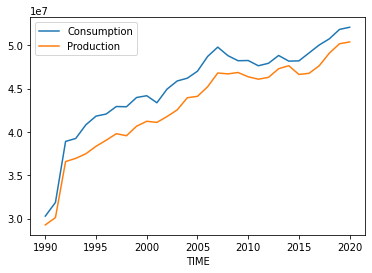

In [26]:
new_df['Consumption'] = new_df['Consumption'] * 1000
new_df.where(new_df['Item']=='BEEF').groupby('TIME').sum().plot()